In [1]:
#System Imports 
import numpy as np
from numpy import pi
import os
from matplotlib.pyplot import plot, legend, title, figure, xlabel, ylabel

#Our imports (should be in the cartpole_sim directory)
import cartpole_modules.cartpole_policy as cpp
import cartpole_modules.cartpole_sim as cps

#TensorFlow imports 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Embedding, Activation
from tensorflow.keras.constraints import max_norm

#Baseline (install from Github (https://github.com/openai/baselines))
from baselines.common.cmd_util import make_mujoco_env, mujoco_arg_parser
from baselines.common import tf_util as U
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple

#jupyter magic
%matplotlib inline

/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


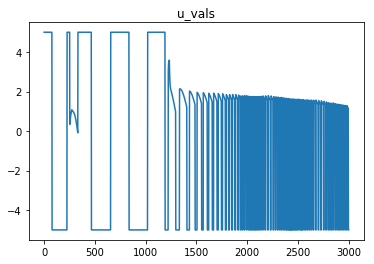

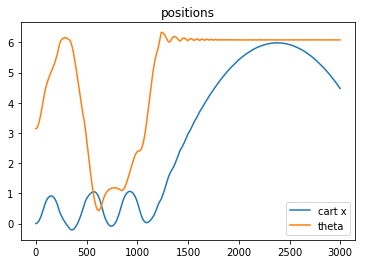

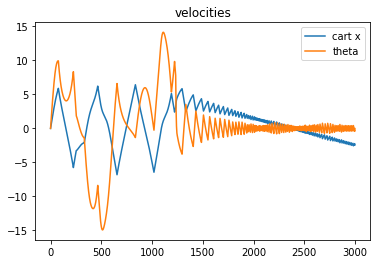

In [2]:
#%%prun #comment to profile

cart = cps.CartPoleSim("cartpole.xml")

theta_vals = [pi]  # 0 is upright, pi is downwards
#theta_vals = np.linspace(pi - .3 , pi + .3,100)
#theta_vals = [pi]
#x_vals = np.linspace(-3 , 3,100)
x_vals = [0]
cart.num_steps = 3000
training_input = None
training_output = None


#cart.default_state[1][1] = pi  # 0 is upright, pi is downwards
#cart.default_state[1][1] = 0
#cart._freeze() #this stops me from being a dummy too often

# you can also change any of the gains before running the sim
cart.Kp = np.array([.1, 3])
cart.Kd = np.array([.1, .2])
cart.Ki = np.array([.2, .2])
cart.i_clip = 4
cart.total_clip = 10
cart.total_gain = 1
cart.swingup_gain = 5
cart.catch_range = .2
cart.swingup_travel = .5


for x in x_vals:
    for theta in theta_vals:
        cart.default_state[1][0] = x
        cart.default_state[1][1] = theta
        cart.run_sim()

        #if(cart.q_pos_hist[:,0].min() < -4.9 or cart.q_pos_hist[:,0].max() > 4.9 ):
        #    continue

        final_angle = cart.q_pos_hist[-1][1] % 2*pi

        #if final_angle > pi:
        #   final_angle -= 2*pi

        #if(final_angle > .4 or final_angle < -.4):
        #    continue 

        #theta = np.reshape(cart.q_pos_hist[:,1], (cart.num_steps,1))
        #pos_and_vel = np.concatenate((theta, cart.q_vel_hist), axis = 1)    
        
        
        pos_and_vel = np.concatenate((cart.q_pos_hist, cart.q_vel_hist), axis = 1)    
        u_and_zero = np.concatenate((cart.u_val_hist, np.zeros((cart.u_val_hist.size,1))), axis = 1) # don't even ask

        if training_input is None:
            training_input = pos_and_vel
            training_output = u_and_zero
        else:
            training_input = np.concatenate((training_input, pos_and_vel))
            training_output = np.concatenate((training_output, u_and_zero))

cart.plot_history()
#cart.visualize()

In [3]:
# Create our LSTM network

look_back = 3000

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(Embedding(1,12,input_length = look_back))
    model.add(LSTM(12, return_sequences = True))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(TimeDistributed(Dense(1)))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

In [4]:
# you can either go ahead and fit the model or load weights, this cell will go ahead and run the fit routine

history = model.fit(np.transpose(training_input), np.transpose(training_output), epochs=20, verbose=0)

plot(history.history['loss'])
title('model loss')
ylabel('loss')
xlabel('epoch')
legend(['train', 'test'], loc='upper left')

ValueError: Error when checking target: expected time_distributed to have 3 dimensions, but got array with shape (2, 3000)